In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from enum import IntEnum
from dataclasses import dataclass
from enum import Enum
import copy
from colorthief import ColorThief
import os
from tqdm import tqdm
from pathlib import Path
from pandas.util import hash_pandas_object
import hashlib


In [34]:
df = pd.read_parquet('../../../datasets/cleaned/polyvore_v1.parquet')

# Calculating like / view ratio

In [35]:
df["Ratio"] = df["outfitLikes"] / df["outfitViews"]

In [36]:
df["Ratio"].describe()

count    30370.000000
mean         0.281321
std          1.311706
min          0.000662
25%          0.090909
50%          0.189711
75%          0.314286
max         54.750000
Name: Ratio, dtype: float64

## Visualize Distribution

<Axes: >

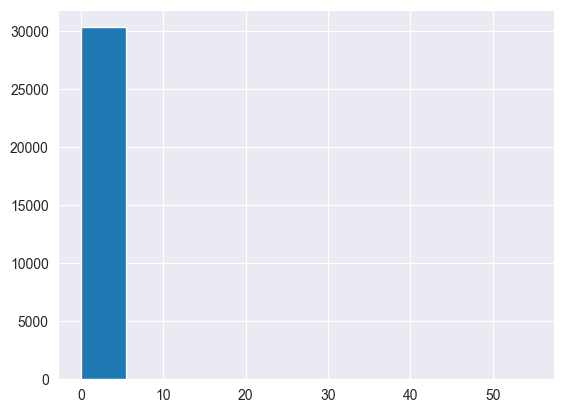

In [37]:
df['Ratio'].hist()

<Axes: >

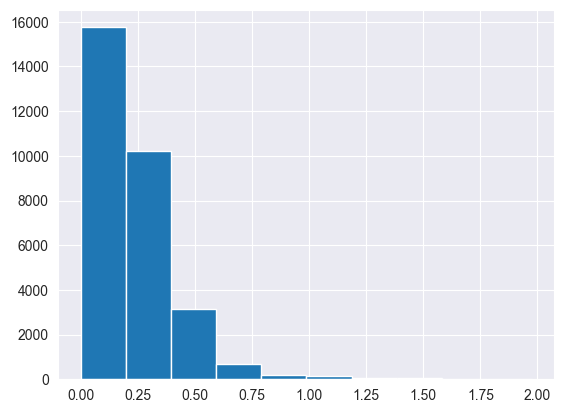

In [38]:
df[df['Ratio'] < 2]['Ratio'].hist()

In [39]:
df = df.drop(df[df["Ratio"] > 1.0].index)

## optimize distribution by taking the logarithm of the ratio

In [40]:
df["Ratio_Log"] = np.log10(df["outfitLikes"] / df["outfitViews"])

<Axes: >

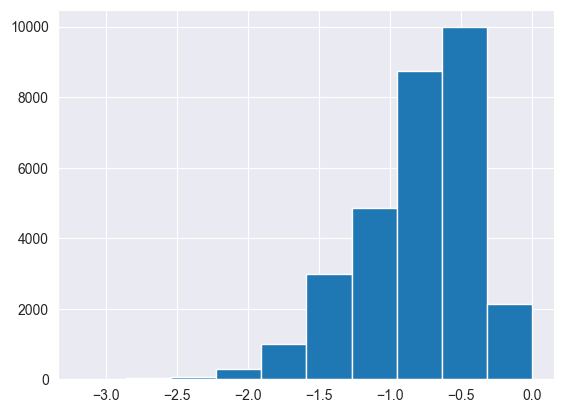

In [41]:
df['Ratio_Log'].hist()

In [42]:
# I want to create a new dataframe with the unique indexes of the setID. So every setID should only appear once.
df_copy = copy.deepcopy(df)
setIDs = df_copy["set_id"].unique()

In [43]:
df.head()

,outfitName,outfitViews,wearType,type,outfitLikes,date,set_id,outfitDesc,clothingItemIndex,clothingItemName,clothingItemPrice,clothingItemLikes,clothingItemCategoryId,imagePath,Ratio,Ratio_Log
7,Being a Vans shoe model with Luke. Idk about t...,188,2.0,top,9,Two years,120161271,A fashion look from April 2014 featuring destr...,1,nirvana distressed t-shirt,10.0,1290,21,raw/images/120161271/1.jpg,0.047872,-1.319915
8,Being a Vans shoe model with Luke. Idk about t...,188,4.0,pants,9,Two years,120161271,A fashion look from April 2014 featuring destr...,2,rag bone rock w/ black skinny jeans,235.0,17406,237,raw/images/120161271/2.jpg,0.047872,-1.319915
15,These Chanel bags is a bad habit .x,562,2.0,top,32,Two years,143656996,12.19.14,1,monki singlet,16.0,20094,104,raw/images/143656996/1.jpg,0.056940,-1.244586
17,These Chanel bags is a bad habit .x,562,4.0,pants,32,Two years,143656996,12.19.14,3,topshop moto joni high rise skinny jeans,65.0,23324,237,raw/images/143656996/3.jpg,0.056940,-1.244586
19,These Chanel bags is a bad habit .x,562,1.0,bag,32,Two years,143656996,12.19.14,5,pre-owned chanel shoulder bag,2450.0,4489,37,raw/images/143656996/5.jpg,0.056940,-1.244586


# Create new dataframe with one row per outfit and items of that outfit as columns

In [44]:
def add_item_to_setID(setID, item, wearType):
    df_setID.loc[setID, f"{wearType} ClothingItemName"] = item["clothingItemName"]
    df_setID.loc[setID, f"{wearType} wearType"] = item["wearType"]
    df_setID.loc[setID, f"{wearType}_imagePath"] = item["imagePath"]


def add_bg_removed_path_to_df(imagePath):
    raw, images, number, file = imagePath.split("/")
    endnumber, end = file.split(".")

    return f"datasets/bg_removed/{number}/{endnumber}.png"


def add_images256x256_path_to_df(imagePath):
    if type(imagePath) != str:
        return None
    raw, images, number, file = imagePath.split("/")

    return f"datasets/images_256x256/{number}/{file}"

In [45]:
df_setID = pd.DataFrame()
for set_id in tqdm(setIDs):
    #Initialisatio
    items = df[df["set_id"] == set_id]
    df_items = pd.DataFrame(items)
    added_accessoire = False

    #Adding the basic information about the SetID
    df_setID.loc[set_id, "OutfitName"] = df[df["set_id"] == set_id]["outfitName"].values[0]
    df_setID.loc[set_id, "outfitDesc"] = df[df["set_id"] == set_id]["outfitDesc"].values[0]
    df_setID.loc[set_id, "outfitViews"] = df[df["set_id"] == set_id]["outfitViews"].values[0]
    df_setID.loc[set_id, "outfitLikes"] = df[df["set_id"] == set_id]["outfitLikes"].values[0]
    df_setID.loc[set_id, "Ratio"] = df[df["set_id"] == set_id]["Ratio_Log"].values[0]

    #Adding the items to the setID
    for index, item in df_items.iterrows():
        if (item["wearType"] == 1.0) and added_accessoire:
            #print("Sorry, es wurde bereits ein Accessoirces hinzugefügt")
            continue
        if (item["wearType"] == 5.0):
            add_item_to_setID(set_id, item, "Shoes")
        elif (item["wearType"] == 4.0):
            add_item_to_setID(set_id, item, "Bottomwear")
        elif (item["wearType"] == 2.0):
            add_item_to_setID(set_id, item, "Innerwear")
        elif (item["wearType"] == 3.0):
            add_item_to_setID(set_id, item, "Outerwear")
        elif (item["wearType"] == 1.0):
            add_item_to_setID(set_id, item, "Accessoire")
            added_accessoire = True
        else:
            #print(item["wearType"])
            raise ValueError("WearType not found")

100%|██████████| 6723/6723 [00:33<00:00, 198.22it/s]


In [46]:
df_setID['Innerwear_imagePath 256x256'] = df_setID['Innerwear_imagePath'].apply(add_images256x256_path_to_df)
df_setID['Bottomwear_imagePath 256x256'] = df_setID['Bottomwear_imagePath'].apply(add_images256x256_path_to_df)
df_setID['Accessoire_imagePath 256x256'] = df_setID['Accessoire_imagePath'].apply(add_images256x256_path_to_df)
df_setID['Shoes_imagePath 256x256'] = df_setID['Shoes_imagePath'].apply(add_images256x256_path_to_df)
df_setID['Outerwear_imagePath 256x256'] = df_setID['Outerwear_imagePath'].apply(add_images256x256_path_to_df)
#df_setID['imagePath BG-Removed'] = df['imagePath'].apply(add_bg_removed_path_to_df)

# Remove unneeded columns

In [47]:
df_setID.drop("OutfitName", inplace=True, axis=1)
df_setID.drop("outfitDesc", inplace=True, axis=1)
df_setID.drop("outfitLikes", inplace=True, axis=1)
df_setID.drop("outfitViews", inplace=True, axis=1)
df_setID.drop("Innerwear wearType", inplace=True, axis=1)
df_setID.drop("Bottomwear ClothingItemName", inplace=True, axis=1)
df_setID.drop("Innerwear ClothingItemName", inplace=True, axis=1)
df_setID.drop("Bottomwear wearType", inplace=True, axis=1)
df_setID.drop("Accessoire ClothingItemName", inplace=True, axis=1)
df_setID.drop("Accessoire wearType", inplace=True, axis=1)
df_setID.drop("Shoes ClothingItemName", inplace=True, axis=1)
df_setID.drop("Shoes wearType", inplace=True, axis=1)
df_setID.drop("Outerwear ClothingItemName", inplace=True, axis=1)
df_setID.drop("Outerwear wearType", inplace=True, axis=1)

In [48]:
df_setID['Accessoire_imagePath'].sample(10)

206710813    raw/images/206710813/5.jpg
175307449    raw/images/175307449/4.jpg
208932351    raw/images/208932351/5.jpg
158291197    raw/images/158291197/4.jpg
164118789    raw/images/164118789/5.jpg
216685944    raw/images/216685944/5.jpg
214125044    raw/images/214125044/5.jpg
113352515                           NaN
204177270                           NaN
193213668    raw/images/193213668/5.jpg
Name: Accessoire_imagePath, dtype: object

# Add Target Variable

In [49]:
q2 = df_setID['Ratio'].describe().loc["50%"]
q1 = df_setID['Ratio'].describe().loc["25%"]
df_setID['valid_outfit_50'] = df_setID['Ratio'].apply(lambda x: 1 if x > q2 else 0)
df_setID['valid_outfit'] = df_setID['Ratio'].apply(lambda x: 1 if x > q1 else 0)
df_setID

,Ratio,Innerwear_imagePath,Bottomwear_imagePath,Accessoire_imagePath,Shoes_imagePath,Outerwear_imagePath,Innerwear_imagePath 256x256,Bottomwear_imagePath 256x256,Accessoire_imagePath 256x256,Shoes_imagePath 256x256,Outerwear_imagePath 256x256,valid_outfit_50,valid_outfit
120161271,-1.319915,raw/images/120161271/1.jpg,raw/images/120161271/2.jpg,NaN,NaN,NaN,datasets/images_256x256/120161271/1.jpg,datasets/images_256x256/120161271/2.jpg,None,None,None,0,0
143656996,-1.244586,raw/images/143656996/1.jpg,raw/images/143656996/3.jpg,raw/images/143656996/5.jpg,NaN,NaN,datasets/images_256x256/143656996/1.jpg,datasets/images_256x256/143656996/3.jpg,datasets/images_256x256/143656996/5.jpg,None,None,0,0
216470135,-0.602060,raw/images/216470135/1.jpg,raw/images/216470135/2.jpg,NaN,raw/images/216470135/3.jpg,NaN,datasets/images_256x256/216470135/1.jpg,datasets/images_256x256/216470135/2.jpg,None,datasets/images_256x256/216470135/3.jpg,None,1,1
216220312,-0.404232,raw/images/216220312/1.jpg,raw/images/216220312/2.jpg,raw/images/216220312/4.jpg,raw/images/216220312/3.jpg,NaN,datasets/images_256x256/216220312/1.jpg,datasets/images_256x256/216220312/2.jpg,datasets/images_256x256/216220312/4.jpg,datasets/images_256x256/216220312/3.jpg,None,1,1
192203629,-0.865301,raw/images/192203629/2.jpg,raw/images/192203629/3.jpg,raw/images/192203629/5.jpg,NaN,raw/images/192203629/1.jpg,datasets/images_256x256/192203629/2.jpg,datasets/images_256x256/192203629/3.jpg,datasets/images_256x256/192203629/5.jpg,None,datasets/images_256x256/192203629/1.jpg,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201717504,-0.585169,raw/images/201717504/1.jpg,raw/images/201717504/2.jpg,raw/images/201717504/4.jpg,raw/images/201717504/3.jpg,NaN,datasets/images_256x256/201717504/1.jpg,datasets/images_256x256/201717504/2.jpg,datasets/images_256x256/201717504/4.jpg,datasets/images_256x256/201717504/3.jpg,None,1,1
216589548,-0.328239,raw/images/216589548/1.jpg,raw/images/216589548/3.jpg,raw/images/216589548/5.jpg,NaN,raw/images/216589548/2.jpg,datasets/images_256x256/216589548/1.jpg,datasets/images_256x256/216589548/3.jpg,datasets/images_256x256/216589548/5.jpg,None,datasets/images_256x256/216589548/2.jpg,1,1
216860218,-0.677760,raw/images/216860218/1.jpg,raw/images/216860218/3.jpg,raw/images/216860218/5.jpg,NaN,raw/images/216860218/2.jpg,datasets/images_256x256/216860218/1.jpg,datasets/images_256x256/216860218/3.jpg,datasets/images_256x256/216860218/5.jpg,None,datasets/images_256x256/216860218/2.jpg,1,1
211099953,-0.337459,raw/images/211099953/1.jpg,raw/images/211099953/2.jpg,NaN,raw/images/211099953/3.jpg,NaN,datasets/images_256x256/211099953/1.jpg,datasets/images_256x256/211099953/2.jpg,None,datasets/images_256x256/211099953/3.jpg,None,1,1


# Remove column ratio

In [50]:
df_setID.drop("Ratio", inplace=True, axis=1)

In [51]:
df_setID

,Innerwear_imagePath,Bottomwear_imagePath,Accessoire_imagePath,Shoes_imagePath,Outerwear_imagePath,Innerwear_imagePath 256x256,Bottomwear_imagePath 256x256,Accessoire_imagePath 256x256,Shoes_imagePath 256x256,Outerwear_imagePath 256x256,valid_outfit_50,valid_outfit
120161271,raw/images/120161271/1.jpg,raw/images/120161271/2.jpg,NaN,NaN,NaN,datasets/images_256x256/120161271/1.jpg,datasets/images_256x256/120161271/2.jpg,None,None,None,0,0
143656996,raw/images/143656996/1.jpg,raw/images/143656996/3.jpg,raw/images/143656996/5.jpg,NaN,NaN,datasets/images_256x256/143656996/1.jpg,datasets/images_256x256/143656996/3.jpg,datasets/images_256x256/143656996/5.jpg,None,None,0,0
216470135,raw/images/216470135/1.jpg,raw/images/216470135/2.jpg,NaN,raw/images/216470135/3.jpg,NaN,datasets/images_256x256/216470135/1.jpg,datasets/images_256x256/216470135/2.jpg,None,datasets/images_256x256/216470135/3.jpg,None,1,1
216220312,raw/images/216220312/1.jpg,raw/images/216220312/2.jpg,raw/images/216220312/4.jpg,raw/images/216220312/3.jpg,NaN,datasets/images_256x256/216220312/1.jpg,datasets/images_256x256/216220312/2.jpg,datasets/images_256x256/216220312/4.jpg,datasets/images_256x256/216220312/3.jpg,None,1,1
192203629,raw/images/192203629/2.jpg,raw/images/192203629/3.jpg,raw/images/192203629/5.jpg,NaN,raw/images/192203629/1.jpg,datasets/images_256x256/192203629/2.jpg,datasets/images_256x256/192203629/3.jpg,datasets/images_256x256/192203629/5.jpg,None,datasets/images_256x256/192203629/1.jpg,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
201717504,raw/images/201717504/1.jpg,raw/images/201717504/2.jpg,raw/images/201717504/4.jpg,raw/images/201717504/3.jpg,NaN,datasets/images_256x256/201717504/1.jpg,datasets/images_256x256/201717504/2.jpg,datasets/images_256x256/201717504/4.jpg,datasets/images_256x256/201717504/3.jpg,None,1,1
216589548,raw/images/216589548/1.jpg,raw/images/216589548/3.jpg,raw/images/216589548/5.jpg,NaN,raw/images/216589548/2.jpg,datasets/images_256x256/216589548/1.jpg,datasets/images_256x256/216589548/3.jpg,datasets/images_256x256/216589548/5.jpg,None,datasets/images_256x256/216589548/2.jpg,1,1
216860218,raw/images/216860218/1.jpg,raw/images/216860218/3.jpg,raw/images/216860218/5.jpg,NaN,raw/images/216860218/2.jpg,datasets/images_256x256/216860218/1.jpg,datasets/images_256x256/216860218/3.jpg,datasets/images_256x256/216860218/5.jpg,None,datasets/images_256x256/216860218/2.jpg,1,1
211099953,raw/images/211099953/1.jpg,raw/images/211099953/2.jpg,NaN,raw/images/211099953/3.jpg,NaN,datasets/images_256x256/211099953/1.jpg,datasets/images_256x256/211099953/2.jpg,None,datasets/images_256x256/211099953/3.jpg,None,1,1


# Split Dataset

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_setID, test_size=0.2, random_state=42, stratify=df_setID["valid_outfit"])

In [60]:
print(df_setID["valid_outfit"].value_counts(normalize=False))
print(X_train["valid_outfit"].value_counts(normalize=True))
print(X_test["valid_outfit"].value_counts(normalize=True))

valid_outfit
1    5042
0    1681
Name: count, dtype: int64
valid_outfit
1    0.749907
0    0.250093
Name: proportion, dtype: float64
valid_outfit
1    0.750186
0    0.249814
Name: proportion, dtype: float64


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


# Aufteilen des Datensatzes in Merkmale (X) und Zielvariable (y)
X = df_setID.drop(columns=["valid_outfit"])
y = df_setID["valid_outfit"]

# Aufteilen des Datensatzes in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Führen Sie das Oversampling der Klasse 0 im Trainingsdatensatz durch
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


# Zusammenfügen der resampleten Daten zu einem DataFrame
train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
test_resampled = pd.concat([X_test, y_test], axis=1)




In [65]:
print(df_setID["valid_outfit"].value_counts(normalize=False))
print(train_resampled["valid_outfit"].value_counts(normalize=True))
print(test_resampled["valid_outfit"].value_counts(normalize=True))

valid_outfit
1    5042
0    1681
Name: count, dtype: int64
valid_outfit
1    0.5
0    0.5
Name: proportion, dtype: float64
valid_outfit
1    0.750186
0    0.249814
Name: proportion, dtype: float64


# Write dataset file

In [66]:
dataset_dir = f'../../../datasets/imageBasedModel/polyvore/median_25percent_resampled_threshold_{hashlib.sha256(df_setID.to_string().encode()).hexdigest()}'
path = Path(dataset_dir)
path.mkdir(parents=True, exist_ok=True)

In [67]:
train_resampled.to_parquet(
    Path(f'{dataset_dir}/polyvore_train_train-resampled_{hashlib.sha256(X_train.to_string().encode()).hexdigest()}.parquet'))
test_resampled.to_parquet(
    Path(f'{dataset_dir}/polyvore_test_train-resampled_{hashlib.sha256(X_test.to_string().encode()).hexdigest()}.parquet'))